In [276]:
# ! pip install arabert
# ! pip install transformers
# ! pip install bert-score

In [277]:
# ! pip install datasets
# ! pip install pandas
# ! pip install torch
# ! pip install numpy



In [278]:
# ! pip install pandas

In [279]:
# ! pip uninstall keras
# ! pip install tensorflow==2.12.0

In [280]:
# ! pip install scikit-learn
# ! pip install arabert
# ! pip install nltk
# ! pip install kagglehub

In [281]:
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU,LayerNormalization, Input,GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import kagglehub
from kagglehub import KaggleDatasetAdapter

import nltk
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pyarabic.araby as araby
from collections import Counter
from nltk.stem.isri import ISRIStemmer 
from sklearn.metrics import  accuracy_score
import matplotlib.pyplot as plt
from arabert.preprocess import ArabertPreprocessor

import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [282]:
# # input_file = 'data.txt'
# # input_file = 'new_data.txt'

# # input_file = 'international_news.txt'
# # input_file = 'cleaned_data.txt'

# # input_file = 'new_data_culure.txt'

# with open(input_file, 'r', encoding='utf-8') as infile:
#     data = infile.read()
    
# data = data.split('\n')


In [283]:
# new_data = []
# for line in data:
#     sentences = line.replace('؟', '.')
#     sentences = line.replace('!', '.')
#     sentences = line.split('.')
#     new_data.extend(sentences)
    
# data = new_data


# sentence_endings = r'(?<=[\.!\؟])\s+'
#     return [s.strip() for s in re.split(sentence_endings, text) if s.strip()]

In [284]:
# data = pd.read_excel('AOC_youm7_articles.xlsx')
data = pd.read_excel('2.Egyptian Tweets.xlsx')
# data = pd.read_xml('')
# data = pd.read_parquet('arabic_chatbot.parquet')

data.head()

,Text,Year,Source
0,review,2019,Arabic Egyptian tweets
1,اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش ...,2019,Arabic Egyptian tweets
2,دائما اكره اخر ليله في كل مكان .,2019,Arabic Egyptian tweets
3,يارب اللى يسرق تويتاتى يدخل النار .,2019,Arabic Egyptian tweets
4,الاسراف فى تناول القهوة يسبب الوفاه .,2019,Arabic Egyptian tweets


In [285]:
# file_path = 'arabic_dataset_classifiction.csv/arabic_dataset_classifiction.csv'
# data = kagglehub.load_dataset(
#             KaggleDatasetAdapter.PANDAS,
#             "saurabhshahane/arabic-classification",
#             file_path
#         )

In [286]:
data.info()
data = data[:10000]
# data = data['output'].astype(str)
data = data['Text'].astype(str)
# data = data['text'].astype(str)
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40001 entries, 0 to 40000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    40001 non-null  object
 1   Year    40001 non-null  int64 
 2   Source  40001 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.7+ KB


0                                               review
1    اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش ...
2                 دائما اكره اخر ليله في كل مكان   .  
3                يارب اللى يسرق تويتاتى يدخل النار .  
4              الاسراف فى تناول القهوة يسبب الوفاه .  
5        انا اتبهدلت من التراب النهارده. حاجة تقرف  . 
6    فى بنات بتلبـس اكســسوارات لدرجــة انك تحــس ا...
7               احتاج صديق حقيقى يواسينى ويخفف عنى .  
8             لازم اتعلم الثبات الانفعالى زيهم كدا .  
9    جروب الدفعه ليلة الامتحان دايما بتحس ان الناس ...
Name: Text, dtype: object

In [287]:
corpus = data.tolist()
# corpus = data #text file
print(corpus[:5])  # Print first 5 lines of the corpus to check the data


['review', 'اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش باخلاقهم هما  .  ', 'دائما اكره اخر ليله في كل مكان   .  ', 'يارب اللى يسرق تويتاتى يدخل النار .  ', 'الاسراف فى تناول القهوة يسبب الوفاه .  ']


# Clean Text

In [288]:
def clean_text(text):
    
    # text = araby.normalize_hamza(text)
    # text = araby.normalize_alef(text)
    # text = araby.normalize_teh(text)
    text = araby.normalize_ligature(text)
    text = araby.strip_tatweel(text)
    text = araby.strip_harakat(text)
    text = araby.strip_tashkeel(text)
    
    # Normalize whitespace and remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    
    # Remove punctuation (custom Arabic punctuation)
    arabic_punctuations = '''`÷×؛<>_()*&^%][،/:',.!?؟{}~¦+|”…“–ـ'''
    all_punctuations = set(arabic_punctuations)
    text = ''.join([char for char in text if char not in all_punctuations])
    
    # Remove non-Arabic characters (optional)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF ]', ' ', text)
    
    
    
    return text

In [289]:
def tokenize_arabic(text):
    text = clean_text(text)
    
    tokens = word_tokenize(text)
    
    # # Remove stopwords 
    # arabic_stopwords = set(stopwords.words('arabic'))
    # tokens = [token for token in tokens if token not in arabic_stopwords]
    
    # # stemmization
    # stemmer = ISRIStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [290]:
corpus = corpus[:5000]
corpus = [tokenize_arabic(str(text)) for text in corpus if text is not None]
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
sequences = tokenizer.texts_to_sequences(corpus)
tokenizer.word_counts

OrderedDict([('اكبر', 10),
             ('خطا', 1),
             ('ترتكبه', 1),
             ('ان', 258),
             ('تعامل', 1),
             ('الناس', 138),
             ('باخلاقك', 1),
             ('انت', 184),
             ('مش', 457),
             ('باخلاقهم', 1),
             ('هما', 20),
             ('دائما', 31),
             ('اكره', 12),
             ('اخر', 22),
             ('ليله', 4),
             ('في', 574),
             ('كل', 394),
             ('مكان', 13),
             ('يارب', 218),
             ('اللى', 213),
             ('يسرق', 1),
             ('تويتاتى', 1),
             ('يدخل', 4),
             ('النار', 7),
             ('الاسراف', 1),
             ('فى', 425),
             ('تناول', 2),
             ('القهوة', 8),
             ('يسبب', 4),
             ('الوفاه', 1),
             ('انا', 477),
             ('اتبهدلت', 2),
             ('من', 886),
             ('التراب', 10),
             ('النهارده', 76),
             ('حاجة', 175),
             ('ت

In [291]:
print(sequences)

[[], [521, 4894, 4895, 14, 4896, 28, 4897, 20, 5, 4898, 259], [153, 429, 228, 1382, 2, 9, 398], [16, 17, 4899, 4900, 1383, 758], [4901, 7, 2743, 671, 1384, 4902], [3, 2744, 1, 522, 55, 23, 1873], [7, 360, 4903, 4904, 592, 50, 319, 14, 7, 4905, 1385, 2745], [1386, 2746, 1387, 4906, 4907, 672], [87, 1388, 4908, 4909, 901, 26], [4910, 4911, 361, 203, 154, 1096, 14, 28, 17, 46, 4912, 4913, 140, 4914, 4915, 6, 4916], [1389, 21, 1097, 4917, 172, 2747, 759, 4918, 4919, 4920, 244, 192], [902, 172, 673, 81, 1874, 2748, 2749, 71], [105, 2750, 2751, 147, 4921, 4922, 229, 1875, 593, 204, 760, 4923], [155, 523, 21, 4924, 4925], [1098, 2752, 2753, 2754, 5, 2752, 4926, 2754], [270, 1390, 761, 95, 4927, 1391], [674, 675, 2755, 1392], [1876, 903, 2756], [762, 17, 4928, 55, 399, 2757, 36], [160, 4929, 4930, 4931, 1877], [62, 2, 4932, 4933, 2, 4934, 1878, 4935, 4936, 2, 1879, 4937, 3, 19, 15, 4938, 4939], [4940, 4941, 4942, 4943, 1393, 2758, 2, 320, 77, 17, 676, 594, 46, 4944, 4945, 4946, 4947, 4948, 762

In [292]:
print(corpus[:5])

[[], ['اكبر', 'خطا', 'ترتكبه', 'ان', 'تعامل', 'الناس', 'باخلاقك', 'انت', 'مش', 'باخلاقهم', 'هما'], ['دائما', 'اكره', 'اخر', 'ليله', 'في', 'كل', 'مكان'], ['يارب', 'اللى', 'يسرق', 'تويتاتى', 'يدخل', 'النار'], ['الاسراف', 'فى', 'تناول', 'القهوة', 'يسبب', 'الوفاه']]


In [293]:
len(corpus)

5000

In [294]:
vocab_size

14941

In [295]:
tokenizer.word_index

{'من': 1,
 'في': 2,
 'انا': 3,
 'و': 4,
 'مش': 5,
 'على': 6,
 'فى': 7,
 'يا': 8,
 'كل': 9,
 'لا': 10,
 'ما': 11,
 'الله': 12,
 'ده': 13,
 'ان': 14,
 'اللي': 15,
 'يارب': 16,
 'اللى': 17,
 'بس': 18,
 'ايه': 19,
 'انت': 20,
 'هو': 21,
 'ربنا': 22,
 'حاجة': 23,
 'لما': 24,
 'ولا': 25,
 'كدا': 26,
 'علي': 27,
 'الناس': 28,
 'عن': 29,
 'دى': 30,
 'حد': 31,
 'مع': 32,
 'اوى': 33,
 'لو': 34,
 'ليه': 35,
 'جدا': 36,
 'يوم': 37,
 'اللهم': 38,
 'والله': 39,
 'بقى': 40,
 'الدنيا': 41,
 'كان': 42,
 'أن': 43,
 'علشان': 44,
 'بعد': 45,
 'فيه': 46,
 'غير': 47,
 'ناس': 48,
 'احنا': 49,
 'انك': 50,
 'اوي': 51,
 'عشان': 52,
 'نفسي': 53,
 'قال': 54,
 'النهارده': 55,
 'الواحد': 56,
 'عليه': 57,
 'دي': 58,
 'كنت': 59,
 'كله': 60,
 'عايز': 61,
 'مصر': 62,
 'عليك': 63,
 'الحياة': 64,
 'عارف': 65,
 'عايزة': 66,
 'هي': 67,
 'وانا': 68,
 'بعض': 69,
 'قبل': 70,
 'فيها': 71,
 'كتير': 72,
 'الا': 73,
 'انام': 74,
 'خير': 75,
 'زى': 76,
 'اليوم': 77,
 'قد': 78,
 'له': 79,
 'حتى': 80,
 'اني': 81,
 'طول': 82,
 'الحمد

In [296]:
# seq_len = 5 # Sequence length

# input_sequences = []
# target_words = []

# for seq in sequences:
#     # Create sequences respecting sentence boundaries
#     for i in range(seq_len, len(seq)-1):
#         # Take the previous 'seq_len' words as context
#         context = seq[i-seq_len:i]
#         target = seq[i]
        
#         # Only add if context doesn't cross sentence boundary
#         input_sequences.append(context)
#         target_words.append(target)

# # Convert to numpy arrays (no padding needed in this approach)
# input_sequences = np.array(input_sequences)
# target_words = np.array(target_words)
# print(input_sequences[:5])
# print(target_words[:5])
# print(input_sequences.shape)    
# print(target_words.shape)

In [ ]:
input_sequences = []
target_words = []
seq_len = 4 # Sequence length

for seq in sequences:
    for i in range(len(seq) - seq_len):
        input_sequences.append(seq[i:i + seq_len])
        target_words.append(seq[i + seq_len])

# Pad sequences to ensure uniform input size
input_sequences = pad_sequences(input_sequences, maxlen=seq_len, padding='pre')
target_words = np.array(target_words)
print(len(input_sequences))
print(len(target_words))
print(input_sequences[:5])
print(target_words[:5])

8783
8783
[[ 521 4894 4895   14 4896   28 4897   20    5 4898]
 [   7  360 4903 4904  592   50  319   14    7 4905]
 [ 360 4903 4904  592   50  319   14    7 4905 1385]
 [4910 4911  361  203  154 1096   14   28   17   46]
 [4911  361  203  154 1096   14   28   17   46 4912]]
[ 259 1385 2745 4912 4913]


In [298]:
X_train1, x_test, y_train1, y_test = train_test_split(input_sequences, target_words, test_size=0.5, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [299]:
from gensim.models import KeyedVectors

def load_pretrained_embeddings(embedding_path, tokenizer):
    word_vectors = KeyedVectors.load(embedding_path, mmap='r')  # for .mdl format
    embedding_dim = word_vectors.vector_size

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]

    return embedding_matrix, embedding_dim

In [312]:
def build_enhanced_lstm_model(vocab_size, seq_len, embedding_matrix=None, embedding_dim=256,hidden_dim=256):
    model = Sequential()
    
    if embedding_matrix is not None:
        # Use pre-trained embeddings
        model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=seq_len,
                        weights=[embedding_matrix],
                        trainable=False))  # Freeze embeddings initially
    else:
        model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=seq_len))

    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(LayerNormalization())

    model.add(Bidirectional(LSTM(hidden_dim)))
    model.add(Dropout(0.1))
    # model.add(LayerNormalization())

    # model.add(Dense(hidden_dim//2, activation='relu'))
    # model.add(Dropout(0.1))
    # model.add(LayerNormalization())
    
    model.add(Dense(vocab_size, activation='softmax'))
    
    return model

In [315]:
embedding_dim = 512 # Increased for richer representations
hidden_dim = 512  # Increased for more capacity

# Load pre-trained embeddings 
embedding_matrix, embedding_dim = load_pretrained_embeddings('full_grams_cbow_100_wiki.mdl', tokenizer)
model = build_enhanced_lstm_model(vocab_size, seq_len, embedding_matrix=embedding_matrix, embedding_dim=embedding_dim,hidden_dim=hidden_dim)

# model = build_enhanced_lstm_model(vocab_size, seq_len, embedding_dim=embedding_dim,hidden_dim= hidden_dim)


initial_learning_rate = 0.0001
optimzer = Adam(learning_rate=initial_learning_rate, clipnorm=1.0)
model.compile(optimizer=optimzer,
            loss='sparse_categorical_crossentropy',
            # loss='categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc'),
                'accuracy'
            ])

d:\NLP_project1\.conda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [316]:
epochs = 20

callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy', mode='max', verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
]

# X_train_small = X_train[:1000]
# y_train_small = y_train[:1000]
# X_val_small = X_val[:200]
# y_val_small = y_val[:200]

# history = model.fit(X_train_small, y_train_small, validation_data=(X_val_small, y_val_small), epochs=3, batch_size=16, verbose=1,callbacks=callbacks) 


history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.0096 - loss: 9.3818 - top3_acc: 0.0220 - top5_acc: 0.0319 - val_accuracy: 0.0216 - val_loss: 8.6907 - val_top3_acc: 0.0466 - val_top5_acc: 0.0592 - learning_rate: 1.0000e-04
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 103s 931ms/step - accuracy: 0.0215 - loss: 7.5163 - top3_acc: 0.0479 - top5_acc: 0.0662 - val_accuracy: 0.0171 - val_loss: 9.0633 - val_top3_acc: 0.0478 - val_top5_acc: 0.0614 - learning_rate: 1.0000e-04
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 103s 940ms/step - accuracy: 0.0369 - loss: 6.9414 - top3_acc: 0.0731 - top5_acc: 0.0940 - val_accuracy: 0.0205 - val_loss: 9.3464 - val_top3_acc: 0.0478 - val_top5_acc: 0.0637 - learning_rate: 1.0000e-04
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0568 - loss: 6.4143 - top3_acc: 0.0990 - top5_acc: 0.1213
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
110/110 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.0567 - loss: 6.

In [303]:
from math import exp

def calculate_perplexity(model, X_test, y_test):
    # Get model predictions (log probabilities)
    predictions = model.predict(X_test, verbose=0)
    log_probs = np.log(np.max(predictions, axis=1))
    
    # Calculate perplexity
    cross_entropy = -np.mean(log_probs)
    perplexity = exp(cross_entropy)
    return perplexity

perplexity = calculate_perplexity(model, x_test, y_test)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 528.78


In [304]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, X_test, y_test, k_list=[1, 3, 5]):
    predictions = model.predict(X_test, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    
    results = {}
    results['accuracy'] = accuracy_score(y_test, y_pred)
    
    for k in k_list:
        top_k_pred = np.argsort(predictions, axis=1)[:, -k:]
        results[f'top_{k}_accuracy'] = np.mean([y_test[i] in top_k_pred[i] for i in range(len(y_test))])
    
    return results

metrics = evaluate_model(model, x_test, y_test)
print("Test Metrics:", metrics)

Test Metrics: {'accuracy': 0.02185792349726776, 'top_1_accuracy': 0.02185792349726776, 'top_3_accuracy': 0.04895264116575592, 'top_5_accuracy': 0.06420765027322405}


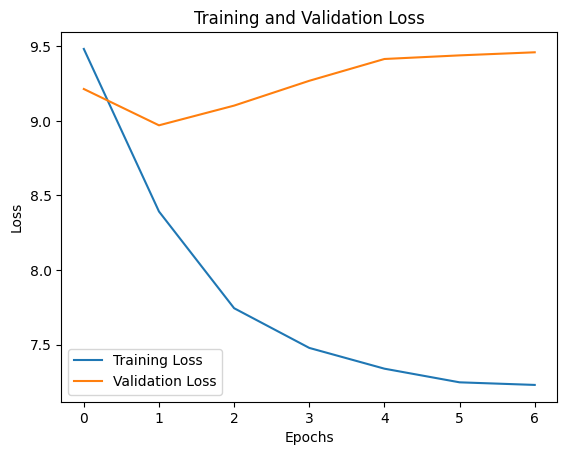

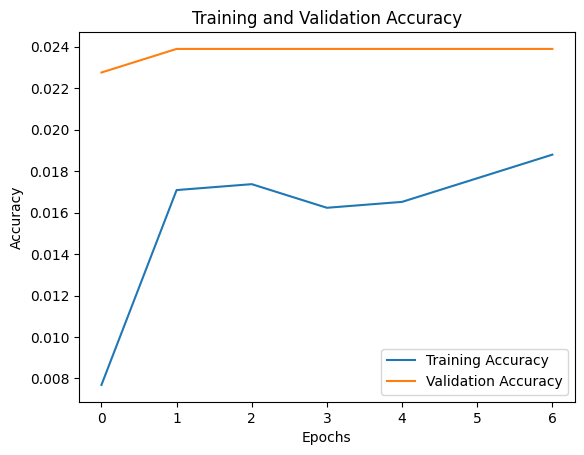

In [305]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [306]:
def predict_next_word(model, tokenizer, text, seq_len):
    # Tokenize and pad the input text
    tokenized_text = tokenizer.texts_to_sequences([text])[0]
    padded_text = pad_sequences([tokenized_text[-seq_len:]], maxlen=seq_len, padding='pre')
    
    # Predict the next word
    predictions = model.predict(padded_text)
    predicted_index = np.argmax(predictions, axis=-1)[0]
    
    # Map index back to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            return word
    return "<UNK>"

def predict_top_five_words(model, tokenizer, text, seq_len):
    # Tokenize and pad the input text
    tokenized_text = tokenizer.texts_to_sequences([text])[0]
    padded_text = pad_sequences([tokenized_text[-seq_len:]], maxlen=seq_len, padding='pre')

    # Predict the next word probabilities
    predictions = model.predict(padded_text, verbose=0)[0]

    # Get top 5 indices
    top_five_indexes = np.argsort(predictions)[::-1][:5]

    # Map indices back to words
    top_five_words = []
    for idx in top_five_indexes:
        for word, index in tokenizer.word_index.items():
            if index == idx:
                top_five_words.append(word)
                break

    return top_five_words



In [307]:
test_sentence = " اذهب"  # Example sentence
next_word = predict_next_word(model, tokenizer, test_sentence, seq_len)
print(f"Next word after '{test_sentence}': {next_word}")
print("Top 5 predictions: ", predict_top_five_words(model, tokenizer, test_sentence, seq_len))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Next word after ' اذهب': من
Top 5 predictions:  ['من', 'في', 'و', 'ما', 'الله']


In [319]:
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, 
                            QLabel, QTextEdit, QPushButton, QWidget, QComboBox,QFileDialog)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QFont, QColor, QPalette

# Add these methods to your GUI class


class ArabicTextPredictorGUI(QMainWindow):
    def __init__(self, model, tokenizer, seq_len):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.initUI()
        
    def save_model(self):
        options = QFileDialog.Options()
        filename, _ = QFileDialog.getSaveFileName(self, "Save Model", "", "H5 Files (*.h5);;All Files (*)", options=options)
        if filename:
            self.model.save(filename)
            self.statusBar().showMessage(f"Model saved to {filename}")

    def load_model(self):
        options = QFileDialog.Options()
        filename, _ = QFileDialog.getOpenFileName(self, "Load Model", "", "H5 Files (*.h5);;All Files (*)", options=options)
        if filename:
            self.model = tf.keras.models.load_model(filename)
            self.statusBar().showMessage(f"Model loaded from {filename}")
        
    def initUI(self):
        # Main window settings
        self.setWindowTitle('Arabic Text Predictor')
        self.setGeometry(100, 100, 800, 600)
        
        # Set Arabic-friendly font
        font = QFont()
        font.setFamily("Arial")  # Or use "Traditional Arabic" if available
        font.setPointSize(14)
        
        # Central widget
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        
        # Main layout
        main_layout = QVBoxLayout()
        central_widget.setLayout(main_layout)
        
        # Title label
        title_label = QLabel("Arabic Text Prediction")
        title_label.setFont(QFont("Arial", 18, QFont.Bold))
        title_label.setAlignment(Qt.AlignCenter)
        main_layout.addWidget(title_label)
        
        # Text input
        self.text_input = QTextEdit()
        self.text_input.setFont(font)
        self.text_input.setPlaceholderText("Type Arabic text here...")
        self.text_input.setAlignment(Qt.AlignRight)  # Right-align for Arabic
        main_layout.addWidget(self.text_input)
        
        # Prediction controls layout
        controls_layout = QHBoxLayout()
        
        # Prediction type dropdown
        self.pred_type = QComboBox()
        self.pred_type.addItems(["Next Word", "Top 5 Suggestions"])
        self.pred_type.setFont(font)
        controls_layout.addWidget(self.pred_type)
        
        # Predict button
        predict_btn = QPushButton("Predict")
        predict_btn.setFont(font)
        predict_btn.clicked.connect(self.predict_text)
        controls_layout.addWidget(predict_btn)
        
        # Clear button
        clear_btn = QPushButton("Clear")
        clear_btn.setFont(font)
        clear_btn.clicked.connect(self.clear_text)
        controls_layout.addWidget(clear_btn)
        
        save_btn = QPushButton("Save Model")
        save_btn.setFont(font)
        save_btn.clicked.connect(self.save_model)
        controls_layout.addWidget(save_btn)

        load_btn = QPushButton("Load Model")
        load_btn.setFont(font)
        load_btn.clicked.connect(self.load_model)
        controls_layout.addWidget(load_btn)
                
        main_layout.addLayout(controls_layout)
        
        # Prediction output
        self.prediction_output = QTextEdit()
        self.prediction_output.setFont(font)
        self.prediction_output.setAlignment(Qt.AlignRight)
        self.prediction_output.setReadOnly(True)
        
        # Set background color for output
        palette = self.prediction_output.palette()
        palette.setColor(QPalette.Base, QColor(240, 240, 240))
        self.prediction_output.setPalette(palette)
        
        main_layout.addWidget(self.prediction_output)
        
        # Status bar
        self.statusBar().showMessage("Ready")
    
    def predict_text(self):
        input_text = self.text_input.toPlainText().strip()
        
        if not input_text:
            self.statusBar().showMessage("Please enter some text first")
            return
        
        try:
            # Preprocess and tokenize input
            tokens = self.tokenizer.texts_to_sequences([input_text])[0]
            
            if len(tokens) < self.seq_len:
                self.statusBar().showMessage(f"Please enter at least {self.seq_len} words")
                return
            
            # Take the last seq_len tokens
            seq = tokens[-self.seq_len:]
            padded_seq = pad_sequences([seq], maxlen=self.seq_len, padding='pre')
            
            # Make prediction
            pred_type = self.pred_type.currentText()
            
            if pred_type == "Next Word":
                predictions = self.model.predict(padded_seq, verbose=0)
                predicted_idx = np.argmax(predictions, axis=-1)[0]
                predicted_word = self.tokenizer.index_word.get(predicted_idx, "<UNK>")
                
                self.prediction_output.setPlainText(predicted_word)
                self.statusBar().showMessage("Prediction complete")
                
            elif pred_type == "Top 5 Suggestions":
                predictions = self.model.predict(padded_seq, verbose=0)[0]
                top_indices = np.argsort(predictions)[-5:][::-1]
                top_words = [self.tokenizer.index_word.get(idx, "<UNK>") for idx in top_indices]
                top_probs = [predictions[idx] for idx in top_indices]
                
                result = "\n".join([f"{word} ({prob:.2%})" for word, prob in zip(top_words, top_probs)])
                self.prediction_output.setPlainText(result)
                self.statusBar().showMessage("Top 5 predictions generated")
                
        except Exception as e:
            self.statusBar().showMessage(f"Error: {str(e)}")
            self.prediction_output.setPlainText("")
    
    def clear_text(self):
        self.text_input.clear()
        self.prediction_output.clear()
        self.statusBar().showMessage("Cleared")


app = QApplication(sys.argv)

# Set application style (optional)
app.setStyle('Fusion')

# For better Arabic text handling
app.setLayoutDirection(Qt.RightToLeft)

# Create and show the GUI
gui = ArabicTextPredictorGUI(model, tokenizer, seq_len)
gui.show()

sys.exit(app.exec_())

SystemExit: 0

d:\NLP_project1\.conda\Lib\site-packages\IPython\core\interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
